<a href="https://colab.research.google.com/github/julrods/cyber-bullying-detector/blob/main/2_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REFERENCIA: https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d#011a

- Javi: preguntar GCP
- Probar binaria de nuevo, debería ir mejor
- Este modelo es diferente al del ejemplo porque hay una Red densa metida en TFBErt for seq classification, no la ponemos manual. Por eso también le pasamos la máscara y el validation data de manera diferente al hacer fit


Next steps:
- 0. Conectar Jupyter a VM de GCP. 
- 0. Hacer predict con train para ver si hay overfitting
- 1. Reentrenar con los mismo datos (aggression): Ver vector de losses (guardar) y añadir al nuevo vector cuando reentrene. 
- 2. Hacer epochs hasta que converja (llegue al mínimo). El modelo tiene un vector de losses y otro de accuracy. Buscar el mínimo de validation. 
- 3. Probar con todos los datos: usar los pesos que tengo y volverlo a entrenar con nuevos datos (cargar pesos antes de entrenar).
- (4? Según cómo lo vea hacer resampling. )
- 5. Productizarlo: Coger datos reales y clasificarlos. Buscar usuario de twitter con tweets ofensivos + usuario no ofensivo. Spider para scrappear IG. Dataset del https://projecte-equal.com/#dades

Dudas: 
- Mirar el tema de la transformación al castellano
- Pasa algo por haber cogido el código de la chica?
- Cómo subo files tan grandes a github?

VMs: 
- https://towardsdatascience.com/running-jupyter-notebook-in-google-cloud-platform-in-15-min-61e16da34d52
- https://medium.com/swlh/how-to-use-google-cloud-and-gpu-build-simple-deep-learning-environment-c6eadff2a569

Future improvements: 
- Reduce overfitting by increasing dropout and adding regularization. Build the model with TFBertModel instead of TFBertForSequenceClassification

# Environment

## Libraries

In [ ]:
!pip install transformers

In [24]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import keras
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.utils import shuffle
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Functions

In [5]:
def load_vectors(dataset_name):
  pickle_inp_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/data/3_tokenized_data/bert_inp_{dataset_name}.pkl'
  pickle_mask_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/data/3_tokenized_data/bert_mask_{dataset_name}.pkl'
  pickle_label_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/data/3_tokenized_data/bert_label_{dataset_name}.pkl'

  input_ids = pickle.load(open(pickle_inp_path, 'rb'))
  attention_masks = pickle.load(open(pickle_mask_path, 'rb'))
  labels = pickle.load(open(pickle_label_path, 'rb'))

  return input_ids, attention_masks, labels

In [6]:
def train_test_val(input_ids, attention_masks, labels):
  train_inp, test_inp, train_mask, test_mask, train_label, test_label = train_test_split(input_ids,
                                                                                         attention_masks,
                                                                                         labels,
                                                                                         test_size = 0.2,
                                                                                         random_state = 42,
                                                                                         stratify = labels)
  
  train_inp, val_inp, train_mask, val_mask, train_label, val_label = train_test_split(train_inp,
                                                                                      train_mask,
                                                                                      train_label,
                                                                                      test_size = 0.2,
                                                                                      random_state = 42,
                                                                                      stratify = train_label)
  
  return train_inp, val_inp, test_inp, train_mask, val_mask, test_mask, train_label, val_label, test_label

In [7]:
def bert_setup():
  base_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,
                                       epsilon=1e-08)
  
  base_model.compile(loss = loss, optimizer = optimizer, metrics = [metric])
  
  return base_model

In [8]:
def train_model(base_model, new_model_name, old_model_name=None, batch_size=32, epochs=4):

  new_model = base_model
  new_model_save_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/models/{new_model_name}.h5'
  print(f'\nNew model will be saved at {new_model_save_path}')

  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = new_model_save_path,
                                                  save_weights_only = True,
                                                  monitor = 'val_loss',
                                                  mode = 'min',
                                                  save_best_only = True)]

  if old_model_name: 
    old_model_save_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/models/{old_model_name}.h5'
    new_model.load_weights(old_model_save_path)
    print(f'\nTraining on previous model {old_model_name}')
  else:
    print('\nTraining new model')
  
  print('\nTraining starting...\n\n')
  history = new_model.fit(x = [train_inp, train_mask],
                           y = train_label,
                           batch_size = batch_size,
                           epochs = epochs,
                           validation_data = ([val_inp, val_mask], val_label), 
                           callbacks = callbacks)
  return new_model

In [9]:
def evaluate_model(model_name, inputs, mask, labels, base_model=None):
  if type(model_name) == str:
    model_save_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/models/{model_name}.h5'
    trained_model = base_model.load_weights(model_save_path)
  
  else:
    trained_model = model_name
  
  preds = trained_model.predict([inputs, mask],
                                batch_size=32)
  
  pred_labels = [np.argmax(pred) for pred in preds[0]]
  f1 = f1_score(labels, pred_labels)
  class_report = classification_report(labels, pred_labels)
  conf_matrix = confusion_matrix(labels, pred_labels)

  return preds, pred_labels, f1, class_report, conf_matrix

In [10]:
def print_eval(f1, class_report, conf_matrix):
  print('F1 score:', f1)
  print('Classification Report:')
  print(class_report)
  print('Confusion Matrix:')
  print(conf_matrix)

In [11]:
# uptading the train_model function to have it save history as well

def train_model(base_model, new_model_name, old_model_name=None, batch_size=32, epochs=4):

  new_model = base_model
  new_model_save_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/models/{new_model_name}.h5'
  print(f'\nNew model will be saved at {new_model_save_path}')

  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = new_model_save_path,
                                                  save_weights_only = True,
                                                  monitor = 'val_loss',
                                                  mode = 'min',
                                                  save_best_only = True)]

  if old_model_name: 
    old_model_save_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/models/{old_model_name}.h5'
    new_model.load_weights(old_model_save_path)
    print(f'\nTraining on previous model {old_model_name}')
  else:
    print('\nTraining new model')
  
  #Training
  print('\nTraining starting...\n\n')
  history = new_model.fit(x = [train_inp, train_mask],
                           y = train_label,
                           batch_size = batch_size,
                           epochs = epochs,
                           validation_data = ([val_inp, val_mask], val_label), 
                           callbacks = callbacks)
  
  #Saving the history
  history_save_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/models/histories/{new_model_name}_hist.pkl'
  print(f'\nFinished training. Saving history at {history_save_path} ...')
  pickle.dump((history.history), open(history_save_path,'wb'))


  return new_model, history.history

In [25]:
def plot_history(history, metric='loss'):
  # retrieve history
  if type(history) == str:
    history_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/models/histories/{history}.pkl'
    hist = pickle.load(open(history_path, 'rb'))

  else:
    hist = history

  #plot: 

  plt.plot(np.arange(len(hist[f'{metric}'])) + 0.5, hist[f'{metric}'], 'b.', label=f'Training {metric}')
  plt.plot(np.arange(len(hist[f'val_{metric}'])) + 1, hist[f'val_{metric}'], 'r-', label=f'Validation {metric}')
  plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
  plt.legend(fontsize=14)
  plt.xlabel('Epochs')
  plt.ylabel(f'{metric.capitalize()}')
  plt.grid(True)  
  plt.show()

# BERT model setup

Read about callbacks: https://keras.io/api/callbacks/

In [13]:
base_model = bert_setup()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Fine-tuning the pre-trained BERT model

## Aggression dataset

### Loading the data from the pickle files

In [ ]:
input_ids, attention_masks, labels = load_vectors('aggression')

### Spitting into train, test and validation set

In [ ]:
train_inp, val_inp, test_inp, train_mask, val_mask, test_mask, train_label, val_label, test_label = train_test_val(input_ids, attention_masks, labels)

### Training the model

In [ ]:
aggression_model = train_model(base_model=base_model, new_model_name='aggression_model', old_model_name='bert_model')


New model will be saved at /content/gdrive/MyDrive/Cyber-bullying-project/models/aggression_model.h5

Training on previous model bert_model

Training starting...


Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the

### Evaluating the model

#### With train data

In [ ]:
preds_train, pred_labels_train, f1_train, class_report_train, conf_matrix_train = evaluate_model(aggression_model, train_inp, train_mask, train_label)

In [ ]:
print_eval(f1_train, class_report_train, conf_matrix_train)

F1 score: 0.9821220776473077
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64691
           1       0.98      0.98      0.98      9461

    accuracy                           1.00     74152
   macro avg       0.99      0.99      0.99     74152
weighted avg       1.00      1.00      1.00     74152

Confusion Matrix:
[[64530   161]
 [  177  9284]]


#### With test data

In [ ]:
preds_test, pred_labels_test, f1_test, class_report_test, conf_matrix_test = evaluate_model(aggression_model, test_inp, test_mask, test_label)

In [ ]:
print_eval(f1_test, class_report_test, conf_matrix_test)

F1 score: 0.759124087591241
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     20217
           1       0.82      0.70      0.76      2956

    accuracy                           0.94     23173
   macro avg       0.89      0.84      0.86     23173
weighted avg       0.94      0.94      0.94     23173

Confusion Matrix:
[[19773   444]
 [  876  2080]]


In [ ]:
# hacer gráfico 

## Aggression dataset - training from scratch

### Training the model

In [ ]:
load_vectors(dataset_name)

In [ ]:
aggression_model_new = train_model(base_model=base_model, new_model_name='aggression_model_new')


New model will be saved at /content/gdrive/MyDrive/Cyber-bullying-project/models/aggression_model_new.h5

Training new model

Training starting...


Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with 

We can see that we have the best results (lowest loss and highest accuracy) for the validation set in the first epoch. After that, the model starts overfitting, as the results improve for the training set but they get worse for the validation set. Therefore we will limit the training to one epoch and see if we have better results with the test set. 

### Evaluating the model

#### With train data

In [ ]:
preds_train, pred_labels_train, f1_train, class_report_train, conf_matrix_train = evaluate_model(aggression_model_new, train_inp, train_mask, train_label)

In [ ]:
print_eval(f1_train, class_report_train, conf_matrix_train)

F1 score: 0.980590629239278
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64691
           1       0.97      0.99      0.98      9461

    accuracy                           0.99     74152
   macro avg       0.98      0.99      0.99     74152
weighted avg       1.00      0.99      1.00     74152

Confusion Matrix:
[[64383   308]
 [   64  9397]]


#### With test data

In [ ]:
preds_test, pred_labels_test, f1_test, class_report_test, conf_matrix_test = evaluate_model(aggression_model_new, test_inp, test_mask, test_label)

In [ ]:
print_eval(f1_test, class_report_test, conf_matrix_test)

F1 score: 0.7467543138866065
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     20217
           1       0.73      0.77      0.75      2956

    accuracy                           0.93     23173
   macro avg       0.85      0.86      0.85     23173
weighted avg       0.94      0.93      0.93     23173

Confusion Matrix:
[[19360   857]
 [  684  2272]]


In [ ]:
# hacer gráfico de cuando converge y quedarme con esas epochs
# how to handle overfitting?
# falta subir datos al repo

## Aggression dataset - 1 epoch

### Loading the data from the pickle files

In [14]:
input_ids, attention_masks, labels = load_vectors('aggression')

### Spitting into train, test and validation set

In [15]:
train_inp, val_inp, test_inp, train_mask, val_mask, test_mask, train_label, val_label, test_label = train_test_val(
    input_ids, attention_masks, labels)

### Training the model

In [16]:
aggression_model_1epoch, history = train_model(
    base_model=base_model, new_model_name='aggression_model_1epoch', epochs=1)


New model will be saved at /content/gdrive/MyDrive/Cyber-bullying-project/models/aggression_model_1epoch.h5

Training new model

Training starting...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.aut

### Evaluating the model

#### With train data

In [17]:
preds_train, pred_labels_train, f1_train, class_report_train, conf_matrix_train = evaluate_model(
    aggression_model_1epoch, train_inp, train_mask, train_label)

In [18]:
print_eval(f1_train, class_report_train, conf_matrix_train)

F1 score: 0.830719131614654
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     64691
           1       0.85      0.81      0.83      9461

    accuracy                           0.96     74152
   macro avg       0.91      0.89      0.90     74152
weighted avg       0.96      0.96      0.96     74152

Confusion Matrix:
[[63380  1311]
 [ 1808  7653]]


#### With test data

In [20]:
preds_test, pred_labels_test, f1_test, class_report_test, conf_matrix_test = evaluate_model(
    aggression_model_1epoch, test_inp, test_mask, test_label)

In [21]:
print_eval(f1_test, class_report_test, conf_matrix_test)

F1 score: 0.7775453277545327
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     20217
           1       0.80      0.75      0.78      2956

    accuracy                           0.94     23173
   macro avg       0.88      0.86      0.87     23173
weighted avg       0.94      0.94      0.94     23173

Confusion Matrix:
[[19667   550]
 [  726  2230]]


## Kaggle dataset - 1 epoch

### Loading the data from the pickle files

In [28]:
input_ids, attention_masks, labels = load_vectors('kaggle')

### Spitting into train, test and validation set

In [29]:
train_inp, val_inp, test_inp, train_mask, val_mask, test_mask, train_label, val_label, test_label = train_test_val(
    input_ids, attention_masks, labels)

### Training the model

In [31]:
kaggle_model_1epoch, history = train_model(
    base_model=base_model, 
    old_model_name='aggression_model_1epoch', 
    new_model_name='kaggle_model_1epoch', 
    epochs=1)


New model will be saved at /content/gdrive/MyDrive/Cyber-bullying-project/models/kaggle_model_1epoch.h5

Training on previous model aggression_model_1epoch

Training starting...


176/176 [==============================] - 122s 694ms/step - loss: 0.4239 - accuracy: 0.8105 - val_loss: 0.3969 - val_accuracy: 0.8239

Finished training. Saving history at /content/gdrive/MyDrive/Cyber-bullying-project/models/histories/kaggle_model_1epoch_hist.pkl ...


### Evaluating the model

#### With Kaggle train data

In [32]:
preds_train_kaggle, pred_labels_train_kaggle, f1_train_kaggle, class_report_train_kaggle, conf_matrix_train_kaggle = evaluate_model(
    kaggle_model_1epoch, train_inp, train_mask, train_label)

In [33]:
print_eval(f1_train_kaggle, class_report_train_kaggle, conf_matrix_train_kaggle)

F1 score: 0.8232265446224255
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3835
           1       0.85      0.80      0.82      1796

    accuracy                           0.89      5631
   macro avg       0.88      0.87      0.87      5631
weighted avg       0.89      0.89      0.89      5631

Confusion Matrix:
[[3574  261]
 [ 357 1439]]


#### With Kaggle test data

In [34]:
preds_test_kaggle, pred_labels_test_kaggle, f1_test_kaggle, class_report_test_kaggle, conf_matrix_test_kaggle = evaluate_model(
    kaggle_model_1epoch, test_inp, test_mask, test_label)

In [35]:
print_eval(f1_test_kaggle, class_report_test_kaggle, conf_matrix_test_kaggle)

F1 score: 0.7281105990783411
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1199
           1       0.75      0.70      0.73       561

    accuracy                           0.83      1760
   macro avg       0.81      0.80      0.80      1760
weighted avg       0.83      0.83      0.83      1760

Confusion Matrix:
[[1070  129]
 [ 166  395]]


## Kaggle dataset - 10 epochs

### Training the model

In [37]:
kaggle_model_10epochs, history = train_model(
    base_model=base_model, 
    old_model_name='kaggle_model_1epoch', 
    new_model_name='kaggle_model_10epochs', 
    epochs=9)


New model will be saved at /content/gdrive/MyDrive/Cyber-bullying-project/models/kaggle_model_10epochs.h5

Training on previous model kaggle_model_1epoch

Training starting...


Epoch 1/9
176/176 [==============================] - 120s 683ms/step - loss: 0.2915 - accuracy: 0.8718 - val_loss: 0.4574 - val_accuracy: 0.8253
Epoch 2/9
176/176 [==============================] - 119s 675ms/step - loss: 0.1587 - accuracy: 0.9410 - val_loss: 0.5656 - val_accuracy: 0.7891
Epoch 3/9
176/176 [==============================] - 119s 676ms/step - loss: 0.0738 - accuracy: 0.9755 - val_loss: 0.7335 - val_accuracy: 0.8040
Epoch 4/9
176/176 [==============================] - 119s 678ms/step - loss: 0.0491 - accuracy: 0.9822 - val_loss: 0.8115 - val_accuracy: 0.8139
Epoch 5/9
176/176 [==============================] - 119s 676ms/step - loss: 0.0345 - accuracy: 0.9877 - val_loss: 0.9669 - val_accuracy: 0.8061
Epoch 6/9
176/176 [==============================] - 119s 676ms/step - loss: 0.0295 - accuracy: 

### Evaluating the model

#### With Kaggle train data

In [38]:
preds_train_kaggle, pred_labels_train_kaggle, f1_train_kaggle, class_report_train_kaggle, conf_matrix_train_kaggle = evaluate_model(
    kaggle_model_1epoch, train_inp, train_mask, train_label)

In [39]:
print_eval(f1_train_kaggle, class_report_train_kaggle, conf_matrix_train_kaggle)

F1 score: 0.9944227551589515
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3835
           1       1.00      0.99      0.99      1796

    accuracy                           1.00      5631
   macro avg       1.00      1.00      1.00      5631
weighted avg       1.00      1.00      1.00      5631

Confusion Matrix:
[[3828    7]
 [  13 1783]]


#### With Kaggle test data

In [40]:
preds_test_kaggle, pred_labels_test_kaggle, f1_test_kaggle, class_report_test_kaggle, conf_matrix_test_kaggle = evaluate_model(
    kaggle_model_1epoch, test_inp, test_mask, test_label)

In [41]:
print_eval(f1_test_kaggle, class_report_test_kaggle, conf_matrix_test_kaggle)

F1 score: 0.7174721189591077
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1199
           1       0.75      0.69      0.72       561

    accuracy                           0.83      1760
   macro avg       0.80      0.79      0.80      1760
weighted avg       0.82      0.83      0.83      1760

Confusion Matrix:
[[1070  129]
 [ 175  386]]


#### Plotting the accuracy and loss curves

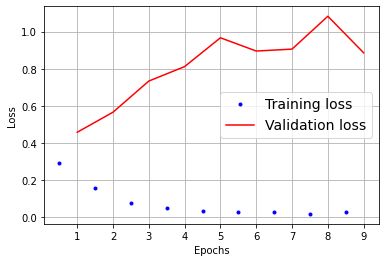

In [42]:
plot_history(history, metric='loss')

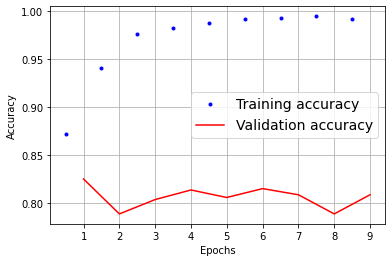

In [43]:
plot_history(history, metric='accuracy')

In [ ]:
# hacer plot de los dos concatenando los dos histories
history_df = pd.concat([pd.DataFrame(history)])

#### With Aggression train data

In [ ]:
print_eval(f1_train, class_report_train, conf_matrix_train)

F1 score: 0.830719131614654
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     64691
           1       0.85      0.81      0.83      9461

    accuracy                           0.96     74152
   macro avg       0.91      0.89      0.90     74152
weighted avg       0.96      0.96      0.96     74152

Confusion Matrix:
[[63380  1311]
 [ 1808  7653]]


#### With Aggression test data

In [ ]:
print_eval(f1_test, class_report_test, conf_matrix_test)

F1 score: 0.7775453277545327
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     20217
           1       0.80      0.75      0.78      2956

    accuracy                           0.94     23173
   macro avg       0.88      0.86      0.87     23173
weighted avg       0.94      0.94      0.94     23173

Confusion Matrix:
[[19667   550]
 [  726  2230]]
